In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, block_until_ready

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize, least_squares
from utils import *
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

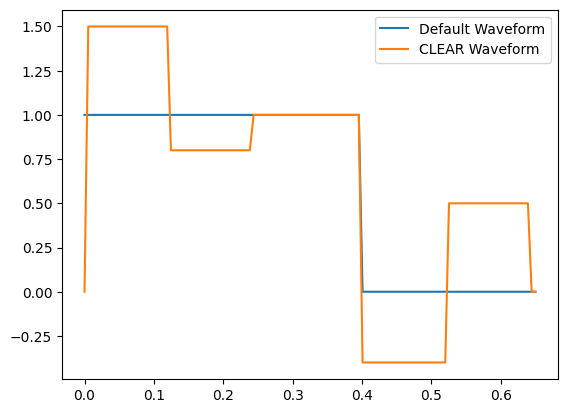

In [7]:
# Construct CLEAR Waveform Optimiser

def add_rect_segment(
    ts: jnp.ndarray,
    waveform: jnp.ndarray,
    amp: float,
    t0: float,
    t1: float,
):
    segment = jnp.heaviside(t1 - ts, 1.) * jnp.heaviside(ts - t0, 0.) * amp
    return waveform + segment

def get_clear_waveform(
    ts: jnp.ndarray,
    ring_up_amp_1: float,
    ring_up_amp_2: float,
    reset_amp_1: float,
    reset_amp_2: float,
    seg_dur: float,
    normal_dur: float,
):
    # Construct a CLEAR Waveform with fixed duration segments, 
    # but variable amplitudes

    clear_waveform = jnp.zeros_like(ts)
    tc = seg_dur

    clear_waveform = add_rect_segment(
        ts,
        clear_waveform,
        ring_up_amp_1,
        0.,
        tc,
    )
    clear_waveform = add_rect_segment(
        ts,
        clear_waveform,
        ring_up_amp_2,
        tc,
        2. * tc,
    )
    clear_waveform = add_rect_segment(
        ts,
        clear_waveform,
        1.,
        2. * tc,
        normal_dur
    )
    clear_waveform = add_rect_segment(
        ts,
        clear_waveform,
        reset_amp_1,
        normal_dur,
        normal_dur + tc
    )
    clear_waveform = add_rect_segment(
        ts,
        clear_waveform,
        reset_amp_2,
        normal_dur + tc,
        normal_dur + 2. * tc
    )
    return clear_waveform

ring_up_amp_1 = 1.5
ring_up_amp_2 = 0.8
reset_amp_1 = -0.4
reset_amp_2 = 0.5
seg_dur = 0.12
normal_dur = 0.4

t0 = 0.
t1 = 0.65
num_ts = 121
ts = jnp.linspace(t0, t1, num_ts)
mu = 1/0.346

clear_waveform = get_clear_waveform(
    ring_up_amp_1=ring_up_amp_1,
    ring_up_amp_2=ring_up_amp_2,
    reset_amp_1=reset_amp_1,
    reset_amp_2=reset_amp_2,
    seg_dur=seg_dur,
    normal_dur=normal_dur,
    ts=ts
)

default_waveform = jnp.heaviside(normal_dur - ts, 1.)

plt.plot(ts, default_waveform, label='Default Waveform')
plt.plot(ts, clear_waveform, label='CLEAR Waveform')
# plt.axhline(y=mu, linestyle='dashed', color='purple')
# plt.axhline(y=-mu, linestyle='dashed', color='purple')
# plt.axhline(y=1., linestyle='dashed', color='black')
# plt.axhline(y=-1., linestyle='dashed', color='black')
plt.legend()
plt.show()

In [135]:
def get_5T_waveform(
    ts: jnp.ndarray,
    ring_up_amp_1: float,
    ring_up_amp_2: float,
    reset_amp_1: float,
    reset_amp_2: float,
    ring_up_time_1: float,
    ring_up_time_2: float,
    reset_time_1: float,
    reset_time_2: float,
    normal_dur: float,
):
    # Construct a CLEAR Waveform with fixed duration segments, 
    # but variable amplitudes

    waveform = jnp.zeros_like(ts)

    waveform = add_rect_segment(
        ts,
        clear_waveform,
        ring_up_amp_1,
        0.,
        ring_up_time_1,
    )
    waveform = add_rect_segment(
        ts,
        clear_waveform,
        ring_up_amp_2,
        ring_up_time_1,
        ring_up_time_1 + ring_up_time_2,
    )
    waveform = add_rect_segment(
        ts,
        clear_waveform,
        1.,
        ring_up_time_1 + ring_up_time_2,
        normal_dur
    )
    waveform = add_rect_segment(
        ts,
        clear_waveform,
        reset_amp_1,
        normal_dur,
        normal_dur + reset_time_1,
    )
    waveform = add_rect_segment(
        ts,
        clear_waveform,
        reset_amp_2,
        normal_dur + reset_time_1,
        normal_dur + reset_time_1 + reset_time_2
    )
    return waveform

## Setting Up Kyoto Env

In [136]:
from env_configs import *
import copy

kyoto_config = get_kyoto_config()
k_config = copy.deepcopy(kyoto_config)
k_config["sim_t1"] = 1.2
kyoto_env = SinglePhotonLangevinReadoutEnv(**k_config)
k_config

{'kappa': 10.07,
 'chi': 5.7805304826052195,
 'kerr': 0.002,
 'time_coeff': 2.0,
 'snr_coeff': 20.0,
 'smoothness_coeff': 1.0,
 'smoothness_baseline_scale': 0.5,
 'gauss_kernel_len': 15,
 'gauss_kernel_std': 2.0,
 'bandwidth': 50.0,
 'freq_relative_cutoff': 0.1,
 'bandwidth_coeff': 0.0,
 'n0': 25.5,
 'tau_0': 0.783,
 'res_amp_scaling': 1.9607843137254901,
 'nR': 0.1,
 'snr_scale_factor': 0.6,
 'gamma_I': 0.0034965034965034965,
 'photon_gamma': 0.0008333333333333334,
 'sim_t1': 1.2,
 'init_fid': 1.0,
 'photon_weight': 8.0,
 'standard_fid': 0.99,
 'shot_noise_std': 0.0}

In [128]:
def optimise_clear(
    env: SinglePhotonLangevinReadoutEnv,
    init_params: jnp.ndarray,
    min_tc: float,
    max_tc: float,
    prep_waveform: bool
):
    ring_up_target = env.actual_max_photons
    reset_target = env._ideal_photon
    mu = env.mu
    bounds = [[-mu, mu] for i in range(len(init_params) - 1)]
    bounds.append([min_tc, max_tc])
    ts = env.ts_action
    ts_sim = env.ts_sim
    normal_dur = env.tau_0

    def get_clear_photon_pops(
        waveform: jnp.ndarray,
        ring_up_time: float,
        reset_time: float,
    ):
        if prep_waveform:
            prepped_waveform = env.prepare_action(waveform)
        else:
            prepped_waveform = jnp.clip(waveform, a_min = -mu, a_max=mu)
            prepped_waveform = prepped_waveform * env.a0
        res = env.calc_results(prepped_waveform)
        res_g = res[:, 0] + 1.0j * res[:, 1]
        photons = jnp.abs(res_g) ** 2
        ring_up_pop = photons[jnp.argmin(jnp.abs(ts_sim - ring_up_time))]
        reset_pop = photons[jnp.argmin(jnp.abs(ts_sim - reset_time))]
        return ring_up_pop, reset_pop
    
    fast_calc_photon_pops = jit(get_clear_photon_pops)

    def fun(x):
        amp_1, amp_2, amp_3, amp_4, tc = x
        # amp_1 = 1.
        # amp_2 = 1.
        clear_waveform = get_clear_waveform(
            ts,
            amp_1,
            amp_2,
            amp_3,
            amp_4,
            tc,
            normal_dur,
        )
        ring_up_pop, reset_pop = fast_calc_photon_pops(
            clear_waveform,
            2. * tc,
            normal_dur + 2. * tc
        )
        ring_up_res = np.abs(ring_up_target - ring_up_pop)
        reset_res = np.abs(reset_target - reset_pop)
        out = np.array([ring_up_res, reset_res])
        out = jnp.sum(out**2)
        return out

    opt_res = minimize(fun, init_params, bounds=bounds, method='Nelder-Mead')
    opt_params = opt_res.x

    print(f"Optimisation Complete, num iterations: {opt_res.nfev}")

    clear_waveform = get_clear_waveform(
        ts,
        *opt_params,
        normal_dur
    )
    ring_up_pop, reset_pop = fast_calc_photon_pops(
        clear_waveform,
        2. * opt_params[-1],
        normal_dur + 2. * opt_params[-1]
    )
    if prep_waveform:
        clear_waveform = env.prepare_action(clear_waveform)
        clear_waveform /= env.a0
    return clear_waveform, opt_params, ring_up_pop, reset_pop

In [137]:
def optimise_5t(
    env: SinglePhotonLangevinReadoutEnv,
    init_params: jnp.ndarray,
    min_tc: float,
    max_tc: float,
    prep_waveform: bool
):
    ring_up_target = env.actual_max_photons
    reset_target = env._ideal_photon
    mu = env.mu
    bounds_1 = [[-mu, mu] for i in range(4)]
    bounds_2 = [[-min_tc, max_tc] for i in range(4)]
    bounds = bounds_1 + bounds_2
    ts = env.ts_action
    ts_sim = env.ts_sim
    normal_dur = env.tau_0

    def get_clear_photon_pops(
        waveform: jnp.ndarray,
        ring_up_time: float,
        reset_time: float,
    ):
        if prep_waveform:
            prepped_waveform = env.prepare_action(waveform)
        else:
            prepped_waveform = jnp.clip(waveform, a_min = -mu, a_max=mu)
            prepped_waveform = prepped_waveform * env.a0
        res = env.calc_results(prepped_waveform)
        res_g = res[:, 0] + 1.0j * res[:, 1]
        photons = jnp.abs(res_g) ** 2
        ring_up_pop = photons[jnp.argmin(jnp.abs(ts_sim - ring_up_time))]
        reset_pop = photons[jnp.argmin(jnp.abs(ts_sim - reset_time))]
        return ring_up_pop, reset_pop
    
    fast_calc_photon_pops = jit(get_clear_photon_pops)

    def fun(x):
        amp_1, amp_2, amp_3, amp_4, t1, t2, t3, t4 = x
        # amp_1 = 1.
        # amp_2 = 1.
        waveform = get_5T_waveform(
            ts,
            amp_1,
            amp_2,
            amp_3,
            amp_4,
            t1,
            t2,
            t3,
            t4,
            normal_dur,
        )
        ring_up_pop, reset_pop = fast_calc_photon_pops(
            waveform,
            t1 + t2,
            normal_dur + t3 + t4
        )
        ring_up_res = np.abs(ring_up_target - ring_up_pop)
        reset_res = np.abs(reset_target - reset_pop)
        out = np.array([ring_up_res, reset_res])
        out = jnp.sum(out**2)
        return out

    opt_res = minimize(fun, init_params, bounds=bounds, method='Nelder-Mead')
    opt_params = opt_res.x

    print(f"Optimisation Complete, num iterations: {opt_res.nfev}")

    clear_waveform = get_5T_waveform(
        ts,
        *opt_params,
        normal_dur
    )
    ring_up_pop, reset_pop = fast_calc_photon_pops(
        clear_waveform,
        opt_params[-4] + opt_params[-3],
        normal_dur + opt_params[-2] + opt_params[-1]
    )
    if prep_waveform:
        clear_waveform = env.prepare_action(clear_waveform)
        clear_waveform /= env.a0
    return clear_waveform, opt_params, ring_up_pop, reset_pop

In [129]:
# Run CLEAR Optimisation
init_params = [1.5, 0.5, -0.5, 0.5, 0.1]

clear_waveform, opt_params, ring_up_pop, reset_pop = optimise_clear(
    kyoto_env,
    init_params=init_params,
    min_tc=0.01,
    max_tc=0.2,
    prep_waveform=False
)

real_clear_waveform, real_opt_params, real_ring_up_pop, real_reset_pop = optimise_clear(
    kyoto_env,
    init_params=init_params,
    min_tc=0.01,
    max_tc=0.2,
    prep_waveform=True
)

Optimisation Complete, num iterations: 421
Optimisation Complete, num iterations: 433


In [138]:
# Run 5T Optimisation
init_params = [1.5, 0.5, -0.5, 0.5, 0.1, 0.1, 0.1, 0.1]

waveform, opt_params, ring_up_pop, reset_pop = optimise_5t(
    kyoto_env,
    init_params=init_params,
    min_tc=0.01,
    max_tc=0.2,
    prep_waveform=False
)

real_waveform, real_opt_params, real_ring_up_pop, real_reset_pop = optimise_5t(
    kyoto_env,
    init_params=init_params,
    min_tc=0.01,
    max_tc=0.2,
    prep_waveform=True
)

Optimisation Complete, num iterations: 341
Optimisation Complete, num iterations: 338


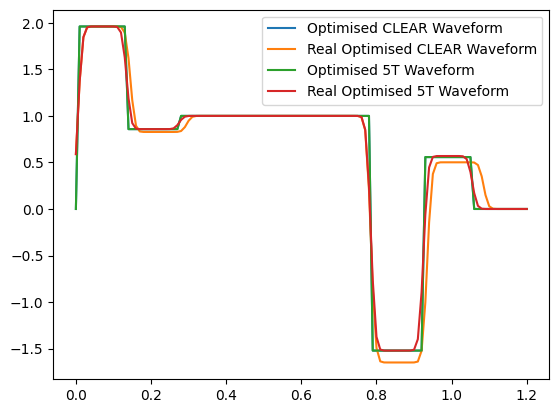

In [139]:
plt.plot(kyoto_env.ts_action, clear_waveform, label='Optimised CLEAR Waveform')
plt.plot(kyoto_env.ts_action, real_clear_waveform, label='Real Optimised CLEAR Waveform')
plt.plot(kyoto_env.ts_action, waveform, label='Optimised 5T Waveform')
plt.plot(kyoto_env.ts_action, real_waveform, label='Real Optimised 5T Waveform')
plt.legend()
plt.show()

In [140]:
print(opt_params)
print(real_opt_params)

[ 8.72264164e-01  4.21884824e-01 -5.23061857e-01  5.57871617e-05
  1.13540323e-01  1.61917307e-01  1.39190835e-01  1.35495410e-01]
[ 1.0846251   0.39825669 -0.44555037  0.01148478  0.12749863  0.16799276
  0.14342182  0.13287943]


In [132]:
print(ring_up_pop)
print(real_ring_up_pop)

print(reset_pop)
print(real_reset_pop)

26.14117704626221
26.141175232195874
0.10000900267585543
0.1000021429634473


In [134]:
print(kyoto_env._ideal_photon)
print(kyoto_env.actual_max_photons)

0.1
26.141176510969785
